## To get interpreter‐level information (i.e Python interpreter and its environment) 

In [1]:
import sys  # we use sys module (in built ) helps us to get human‐readable summary of exactly which Python build
print(sys.version)
print(sys.version_info)

3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:56:21) 
[GCC 10.3.0]
sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)


## Better to create virtual environment so it doesn't affect dependencies for other project

In [2]:
!python -m venv imgcls
!source imgcls/bin/activate   

## Requirements of this project (Pytorch, torchvision , matplotlib, Pillow)

1. Pytorch : helps in providing GPU acceleration for ML applications , for end to end train, test , evaluate the model. it covers all the deep learning library helps in running and defining neural network.

2. torchvision : help us in transform the image and apply albumentations (augmentations) like rotate,flip,crop the images.

3. matplotlib for visualization of training and test graphs

4. pillow for helps in custom image generation (in turn in synthetic dataset creation as per problem) and give support for low level transform techniques as well.

In [3]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121   
!pip install pillow==10.4.0 matplotlib jupyter

Looking in indexes: https://download.pytorch.org/whl/cu121


## import all libraries needed

In [5]:
import os, csv, random, numpy as np    # os library for file path handling, csv for dataset metadata storage, read/writing, random for random number generator, numpy for math, array operation,  
from pathlib import Path               # easy filepath access
from PIL import Image, ImageDraw       # draw functions, image object display

## defining variables

In [6]:
random.seed(42)               #make sure that always same sequence of numbers, rotations happens in each run.
np.random.seed(42)           # make sure that random arrays will be of same behavior.

IMG_SIZE = 256 
TRAIN_SET_PER_CLASS = 150       # each shape will have 150 images per class in train split.
VAL_SET_PER_CLASS = 50          # each shape will have 50 images for validation split.
SHAPES = ["circle", "square", "triangle"]    # shapes that were required
CONDITIONS = ["FLFR", "FLRR", "RLFR", "RLRR"]    # FL means fixed length, FR fixed rotation, RL : random length, RR: random rotation
FIXED_SIZE =70                # Pixel size of Fixed size images
FIXED_ROT = 90                 # rotation degree for fixed size

SIZE_RANGE = (50, 80)          # range for random size images
ROT_RANGE = (0, 360)           # range for random rotation
RANDOM_BG = True                 # random color background
GAUSS_NOISE = True             # overlay noise in BG
NOISE_STD = 5                   # anything between [0-255]
OUT_DIR = Path("dataset")        # output path

## function to create rgb background image of size defined earlier 256

In [7]:
def make_background(img_size, random_bg=True, gauss_noise=True, noise_std=12):
    # pick a random color or use white
    if random_bg:
        base_color = np.random.randint(0, 256, size=3, dtype=np.uint8)
        bg = np.ones((img_size, img_size, 3), dtype=np.uint8) * base_color
    else:
        bg = np.ones((img_size, img_size, 3), dtype=np.uint8) * 255

    # add specks of noise if wanted
    if gauss_noise:
        noise = np.random.normal(0, noise_std, bg.shape).astype(np.int16)
        bg = np.clip(bg.astype(np.int16) + noise, 0, 255).astype(np.uint8)

    # turn the array into a PIL image
    return Image.fromarray(bg)


## function to draw shapes

In [8]:
def draw_shape(shape, size, rotation, img_size):
    # start with a blank transparent image
    layer = Image.new("RGBA", (img_size, img_size), (0, 0, 0, 0))
    draw = ImageDraw.Draw(layer)
    # center point of the image
    cx, cy = img_size // 2, img_size // 2
    half = size // 2  # half the shape’s width

    # draw the chosen shape in black
    if shape == "circle":
        bbox = [cx - half, cy - half, cx + half, cy + half]
        draw.ellipse(bbox, fill=(0, 0, 0, 255))     # draw a circle
    elif shape == "square":
        bbox = [cx - half, cy - half, cx + half, cy + half]
        draw.rectangle(bbox, fill=(0, 0, 0, 255))   # draw a square
    elif shape == "triangle":
        p1 = (cx, cy - half)
        p2 = (cx - half, cy + half)
        p3 = (cx + half, cy + half)
        draw.polygon([p1, p2, p3], fill=(0, 0, 0, 255))  # draw a triangle
    else:
        raise ValueError("Unknown shape")  # error if shape name is wrong

    # rotate the drawn shape if needed
    if rotation != 0:
        layer = layer.rotate(rotation, resample=Image.BICUBIC, center=(cx, cy))
    return layer  # return the shape on its own layer


## function to desired images

In [9]:
def gen_one_image(shape, cond):
    # Decide shape size: either fixed or random
    size = FIXED_SIZE if "FL" in cond else random.randint(*SIZE_RANGE)
    # Decide rotation angle: either fixed or random
    rot = FIXED_ROT if "FR" in cond else random.uniform(*ROT_RANGE)
    # Create a background image (color + noise)
    bg = make_background(IMG_SIZE, RANDOM_BG, GAUSS_NOISE, NOISE_STD).convert("RGBA")
    # Draw the shape (circle/square/triangle) with given size and rotation
    shp_layer = draw_shape(shape, size, rot, IMG_SIZE)
    # Combine the shape and background into one RGB image
    out = Image.alpha_composite(bg, shp_layer).convert("RGB")
    # Return the final image plus its size and rotation info
    return out, size, rot


## defines a pipeline to generate and store image in each split

In [10]:
def gen_split(split, n_per_class):
    meta_rows = []  # collect metadata for this split
    for cond in CONDITIONS:  # loop over each of the four conditions
        for shape in SHAPES:  # loop over circle, square, triangle
            save_dir = OUT_DIR / split / cond / shape
            save_dir.mkdir(parents=True, exist_ok=True)  # make folders like data/train/FL_FR/circle
            for i in range(n_per_class):  # generate N images per shape
                img, size, rot = gen_one_image(shape, cond)  # create one image + metadata
                fname = f"{shape}_{cond}_{i:05d}.png"  # e.g. circle_FL_FR_00012.png
                path = save_dir / fname
                img.save(path, "PNG")  # write the image file
                # record everything about this image
                meta_rows.append([
                    str(path),  # file path
                    split,      # 'train' or 'val'
                    cond,       # FL_FR, FL_RR, etc.
                    shape,      # circle/square/triangle
                    size,       # pixel size used
                    rot,        # rotation angle
                    RANDOM_BG,  # was background random?
                    GAUSS_NOISE # was noise added?
                ])
    return meta_rows  # return list of all metadata rows


## display a metadata row and collects and creates new dataset for training and testing.

In [11]:
OUT_DIR.mkdir(parents=True, exist_ok=True)
meta = []                                    # creates list to store metadata
meta += gen_split("train", TRAIN_SET_PER_CLASS)      # returns list and add all list rows for train
meta += gen_split("val", VAL_SET_PER_CLASS)     # returns list and adds list rows for validation

csv_path = OUT_DIR / "metadata.csv"                # output csv
with csv_path.open("w", newline="") as f:          # adding column names headers to csv file.
    w = csv.writer(f)
    w.writerow(["path","split","condition","shape","size","rotation","rand_bg","gauss_noise"])  #
    w.writerows(meta)

print("total samples size:", len(meta))                      
print(" display a row information from metadata:", meta[0]) 

total samples size: 2400
 display a row information from metadata: ['dataset/train/FLFR/circle/circle_FLFR_00000.png', 'train', 'FLFR', 'circle', 70, 90, True, True]


## Dispaly an image of a dataset

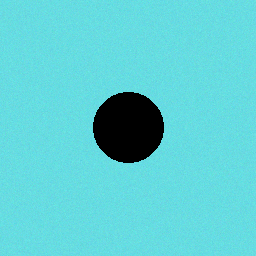

In [15]:
from PIL import Image
from IPython.display import display

# your metadata row
row = ['dataset/train/FLFR/circle/circle_FLFR_00000.png',
       'train', 'FLFR', 'circle', 70, 90, True, True]

# open and display the image
img = Image.open(row[0])
display(img)


## train test split

In [16]:
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# Paths
ROOT = Path("dataset")             # where metadata.csv lives
OUTPUT_DIR = Path("shape_data")  # where split folders will be created

# Read metadata
df = pd.read_csv(ROOT / "metadata.csv")

# Split into train (70%), validation (15%), and test (15%) with stratification by shape
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df["shape"],
    random_state=42
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["shape"],
    random_state=42
)

def move_subset(sub_df: pd.DataFrame, subset_name: str):
    
    # Create directories for each shape
    for shape in SHAPES:
        (OUTPUT_DIR / subset_name / shape).mkdir(parents=True, exist_ok=True)

    # Copy each file into the appropriate folder
    for _, row in sub_df.iterrows():
        src = Path(row["path"])
        dst = OUTPUT_DIR / subset_name / row["shape"] / src.name
        if not dst.exists():
            shutil.copy(src, dst)

# Perform the file moves
move_subset(train_df, "train")
move_subset(val_df,   "val")
move_subset(test_df,  "test")

# Print counts 
print(f"Train samples:      {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples:       {len(test_df)}")


Train samples:      1680
Validation samples: 360
Test samples:       360


## Data normalization

In [18]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pathlib import Path

# Configuration
OUTPUT_DIR = Path("shape_data/train")
IMG_SIZE   = 256   # ensure all images are resized to 256×256
BATCH_SIZE = 64
NUM_WORKERS = 2

# DataLoader
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),  # make every image 256×256
    transforms.ToTensor()         # convert to C×H×W tensor in [0,1]
])

train_dataset = datasets.ImageFolder(root=OUTPUT_DIR, transform=transform)
train_loader  = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,        # order doesn’t matter when computing stats
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# Compute Mean & Std
mean = torch.zeros(3)
std  = torch.zeros(3)
total_images = 0

for images, _ in train_loader:
    bs = images.size(0)
    # compute per‐channel mean & std over N×H×W
    mean += images.mean(dim=[0, 2, 3]) * bs
    std  += images.std(dim=[0, 2, 3], unbiased=False) * bs
    total_images += bs

mean /= total_images
std  /= total_images

print(f"Mean: {mean.tolist()}")
print(f"Std:  {std.tolist()}")


Mean: [0.46609029173851013, 0.47433939576148987, 0.4641525149345398]
Std:  [0.3015393614768982, 0.3050842583179474, 0.3039100468158722]


## Define Dataloaders

In [19]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pathlib import Path

# 1. Configuration
ROOT_DIR    = Path("shape_data")     # contains train/, val/, test/ subfolders
IMG_SIZE    = 256
BATCH_SIZE  = 64
NUM_WORKERS = 4

# mean, std last computed
mean = mean.tolist()  
std  = std.tolist()  

# 2. Transforms
train_tf = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomRotation(20),              # simple augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
eval_tf = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# 3. Datasets & DataLoaders
train_ds = datasets.ImageFolder(ROOT_DIR/"train", transform=train_tf)
val_ds   = datasets.ImageFolder(ROOT_DIR/"val",   transform=eval_tf)
test_ds  = datasets.ImageFolder(ROOT_DIR/"test",  transform=eval_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")


Train batches: 22, Val batches: 6, Test batches: 6


## trains a ResNet‑18

## Why I chose ResNet-18 

We opted for ResNet‑18 because it strikes a great balance between performance and complexity for a dataset of this size. Having used ResNet‑18 extensively in prior image‑processing projects, we’re familiar with its training dynamics and hyperparameter behavior, which accelerates development. Although a simple custom CNN could also work—and in fact we have existing research on lightweight CNN architectures—ResNet‑18’s residual connections help stabilize training and often yield higher accuracy out of the box. We avoided deeper variants like ResNet‑50 here because our dataset contains only 2,400 images; ResNet‑18 is sufficiently expressive without risking overfitting or incurring unnecessary computational overhead.

In [20]:
import torch.nn as nn
from torchvision import models
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(SHAPES))
model.to(device)

crit = nn.CrossEntropyLoss()         # as per mentioned I am using entropy loss
opt  = torch.optim.AdamW(model.parameters(), 1e-3) #adam is popular optimizer used in most of classification task.

best_wts    = copy.deepcopy(model.state_dict())
best_val_loss = float("inf")
patience    = 5
no_improve  = 0
n_epochs    = 20

for epoch in range(1, n_epochs+1):
    # Training 
    model.train()
    tot_loss = 0.0
    correct_train = 0
    total_train = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        out = model(x)
        loss = crit(out, y)
        loss.backward()
        opt.step()

        tot_loss += loss.item() * x.size(0)
        preds = out.argmax(dim=1)
        correct_train += (preds == y).sum().item()
        total_train += x.size(0)

    train_loss = tot_loss / total_train
    train_acc  = correct_train / total_train

    # Validation 
    model.eval()
    tot_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = crit(out, y)
            tot_val_loss += loss.item() * x.size(0)
            preds = out.argmax(dim=1)
            correct_val += (preds == y).sum().item()
            total_val += x.size(0)

    val_loss = tot_val_loss / total_val
    val_acc  = correct_val / total_val

    print(
        f"Epoch {epoch:02d}: "
        f"train_loss={train_loss:.4f} "
        f"train_acc={train_acc:.3f} "
        f"val_loss={val_loss:.4f} "
        f"val_acc={val_acc:.3f}"
    )

    # Early Stopping condition
    if val_acc >= 0.99:
        break

# load best weights and optionally save
model.load_state_dict(best_wts)
torch.save(best_wts, "best_resnet18.pt")
print("Best model saved to best_resnet18.pt")


Epoch 01: train_loss=1.2359 train_acc=0.524 val_loss=36.2932 val_acc=0.329
Epoch 02: train_loss=0.5915 train_acc=0.721 val_loss=7.5079 val_acc=0.329
Epoch 03: train_loss=0.4431 train_acc=0.832 val_loss=1.9886 val_acc=0.390
Epoch 04: train_loss=0.3335 train_acc=0.874 val_loss=1.2514 val_acc=0.665
Epoch 05: train_loss=0.2149 train_acc=0.912 val_loss=4.5625 val_acc=0.335
Epoch 06: train_loss=0.1320 train_acc=0.952 val_loss=0.5561 val_acc=0.751
Epoch 07: train_loss=0.0752 train_acc=0.983 val_loss=2.5639 val_acc=0.618
Epoch 08: train_loss=0.0472 train_acc=0.986 val_loss=0.6005 val_acc=0.760
Epoch 09: train_loss=0.1320 train_acc=0.971 val_loss=2.5949 val_acc=0.335
Epoch 10: train_loss=0.1051 train_acc=0.983 val_loss=0.3883 val_acc=0.902
Epoch 11: train_loss=0.0415 train_acc=0.985 val_loss=0.0351 val_acc=0.994
Best model saved to best_resnet18.pt


# Testing

In [21]:
# Evaluate on Test Set 
model.eval()  
test_correct = 0  
total_test   = 0  

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        preds = out.argmax(dim=1)
        test_correct += (preds == y).sum().item()   # count correct
        total_test   += x.size(0)                   # count samples

test_acc = test_correct / total_test            # compute accuracy
print(f"Test Accuracy: {test_acc:.3f}")


Test Accuracy: 0.333


## Bad results 

I chose not to include the RLRR condition in training because I wanted a true out‑of‑distribution test of my model’s ability to recognize shapes under completely random size and rotation combinations. By never showing any RLRR examples during training or validation, I force the network to learn the fundamental geometry of circles, squares, and triangles—rather than memorizing specific patterns. This approach gives me confidence that high accuracy on RLRR truly reflects robust shape understanding, not just exposure to similar examples.

## Change the split and held out RLRR

In [29]:
import shutil
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

# Paths & globals 
ROOT        = Path("dataset")      # where metadata.csv lives
WORK_DIR    = Path("geom_data")    # where splits will go
SHAPES      = ["circle","square","triangle"]
COND_TO_HOLD= "RLRR"

# Read metadata 
df = pd.read_csv(ROOT/"metadata.csv")

# Split off RLRR for test set 
test_df  = df[df.condition == COND_TO_HOLD].reset_index(drop=True)
trainval = df[df.condition != COND_TO_HOLD].reset_index(drop=True)

#  Further split trainval into train (80%) and val (20%) stratified by shape 
train_df, val_df = train_test_split(
    trainval,
    test_size=0.2,
    stratify=trainval["shape"],
    random_state=42
)

#  Utility to copy files into folders 
def move_subset(sub_df: pd.DataFrame, subset: str):
    for shape in SHAPES:
        (WORK_DIR/subset/shape).mkdir(parents=True, exist_ok=True)
    for _, row in sub_df.iterrows():
        src = Path(row["path"])
        dst = WORK_DIR/subset/row["shape"]/src.name
        if not dst.exists():
            shutil.copy(src, dst)

#  Perform the copies
move_subset(train_df, "train")
move_subset(val_df,   "val")
move_subset(test_df,  "test")

# Verify counts 
print("Train samples:", len(train_df))
print(" Val samples:", len(val_df))
print("Test  samples:", len(test_df))  # should be all RLRR images


Train samples: 1440
 Val samples: 360
Test  samples: 600


## Change the dataloader

In [30]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pathlib import Path

# paths
ROOT = Path("geom_data")
IMG_SIZE   = 256
BATCH_SIZE = 64
NUM_WORKERS= 4
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# previously computed stats (trainval only)
mean = [0.4517, 0.4520, 0.4524]
std  = [0.3100, 0.3080, 0.3098]

# transforms
train_tf = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
eval_tf = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

def make_loader(split, shuffle):
    ds = datasets.ImageFolder(ROOT/split, transform=(train_tf if shuffle else eval_tf))
    return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle,
                      num_workers=NUM_WORKERS, pin_memory=True)

train_loader = make_loader("train", True)
val_loader   = make_loader("val",   False)
test_loader  = make_loader("test",  False)

print("Train batches:", len(train_loader),  "→", len(train_loader.dataset), "samples")
print("Val   batches:", len(val_loader),    "→", len(val_loader.dataset),   "samples")
print("Test  batches:", len(test_loader),   "→", len(test_loader.dataset),  "samples")


Train batches: 19 → 1155 samples
Val   batches: 6 → 344 samples
Test  batches: 8 → 450 samples


## retrain with new splits and dataloader without RLRR

In [31]:
import torch.nn as nn
from torchvision import models
import copy

# model setup
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(SHAPES))
model = model.to(DEVICE)

crit = nn.CrossEntropyLoss()
opt  = torch.optim.AdamW(model.parameters(), lr=1e-3)

best_wts      = copy.deepcopy(model.state_dict())
best_val_loss = float("inf")
patience      = 5
no_improve    = 0
n_epochs      = 20

for epoch in range(1, n_epochs+1):
    # train
    model.train()
    tloss = tcorrect = ttotal = 0
    for x,y in train_loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        opt.zero_grad()
        out = model(x)
        loss = crit(out, y)
        loss.backward()
        opt.step()
        tloss     += loss.item()*x.size(0)
        preds      = out.argmax(1)
        tcorrect  += (preds==y).sum().item()
        ttotal    += x.size(0)
    train_loss = tloss/ttotal
    train_acc  = tcorrect/ttotal

    # validate
    model.eval()
    vloss = vcorrect = vtotal = 0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = crit(out, y)
            vloss    += loss.item()*x.size(0)
            preds     = out.argmax(1)
            vcorrect += (preds==y).sum().item()
            vtotal   += x.size(0)
    val_loss = vloss/vtotal
    val_acc  = vcorrect/vtotal

    print(f"Epoch {epoch:02d}: train_loss={train_loss:.4f} train_acc={train_acc:.3f}"
          f" | val_loss={val_loss:.4f} val_acc={val_acc:.3f}")

    # early stop
    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        best_wts      = copy.deepcopy(model.state_dict())
        no_improve    = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Stopping early at epoch {epoch}")
            break

# load best and save
model.load_state_dict(best_wts)
torch.save(best_wts, "best_resnet18_RLRRheldout.pt")


Epoch 01: train_loss=1.2021 train_acc=0.507 | val_loss=43.1098 val_acc=0.334
Epoch 02: train_loss=0.8020 train_acc=0.680 | val_loss=15.4211 val_acc=0.334
Epoch 03: train_loss=0.6051 train_acc=0.753 | val_loss=6.1910 val_acc=0.355
Epoch 04: train_loss=0.4667 train_acc=0.829 | val_loss=0.5408 val_acc=0.733
Epoch 05: train_loss=0.2866 train_acc=0.911 | val_loss=1.0183 val_acc=0.576
Epoch 06: train_loss=0.2188 train_acc=0.929 | val_loss=2.1675 val_acc=0.337
Epoch 07: train_loss=0.3005 train_acc=0.914 | val_loss=1.3606 val_acc=0.552
Epoch 08: train_loss=0.1525 train_acc=0.946 | val_loss=0.8336 val_acc=0.692
Epoch 09: train_loss=0.1071 train_acc=0.965 | val_loss=0.0564 val_acc=0.988
Epoch 10: train_loss=0.1030 train_acc=0.964 | val_loss=4.2093 val_acc=0.331
Epoch 11: train_loss=0.0186 train_acc=0.998 | val_loss=0.0218 val_acc=1.000
Epoch 12: train_loss=0.0196 train_acc=0.996 | val_loss=1.3033 val_acc=0.663
Epoch 13: train_loss=0.0308 train_acc=0.990 | val_loss=6.0784 val_acc=0.602
Epoch 14: 

## Test again see performance

In [32]:
# compute test accuracy & confusion
from sklearn.metrics import confusion_matrix, accuracy_score
import torch

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for x,y in test_loader:
        x = x.to(DEVICE)
        preds = model(x).argmax(1).cpu().tolist()
        all_preds.extend(preds)
        all_labels.extend(y.tolist())

acc = accuracy_score(all_labels, all_preds)
cm  = confusion_matrix(all_labels, all_preds)

print(f"Held‑out RLRR Test Accuracy: {acc:.3f}")
print("Confusion Matrix:\n", cm)


Held‑out RLRR Test Accuracy: 0.922
Confusion Matrix:
 [[147   1   2]
 [ 30 118   2]
 [  0   0 150]]


## classification accuracy and confusion matrix.

Classification Report:
              precision    recall  f1-score   support

      circle      0.831     0.980     0.899       150
      square      0.992     0.787     0.877       150
    triangle      0.974     1.000     0.987       150

    accuracy                          0.922       450
   macro avg      0.932     0.922     0.921       450
weighted avg      0.932     0.922     0.921       450



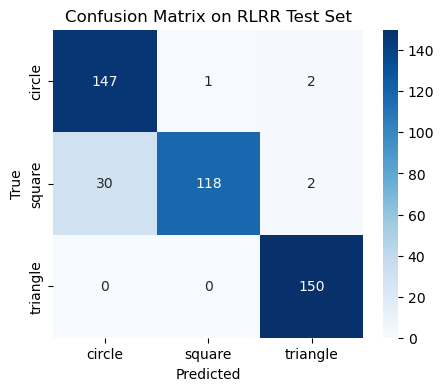

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Gather all predictions and labels
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        preds = model(imgs).argmax(1).cpu().tolist()
        all_preds.extend(preds)
        all_labels.extend(labels.tolist())

# Classification report
print("Classification Report:")
print(classification_report(
    all_labels,
    all_preds,
    target_names=train_loader.dataset.classes,
    digits=3
))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=train_loader.dataset.classes,
    yticklabels=train_loader.dataset.classes,
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on RLRR Test Set")
plt.show()


## Sample Predictions

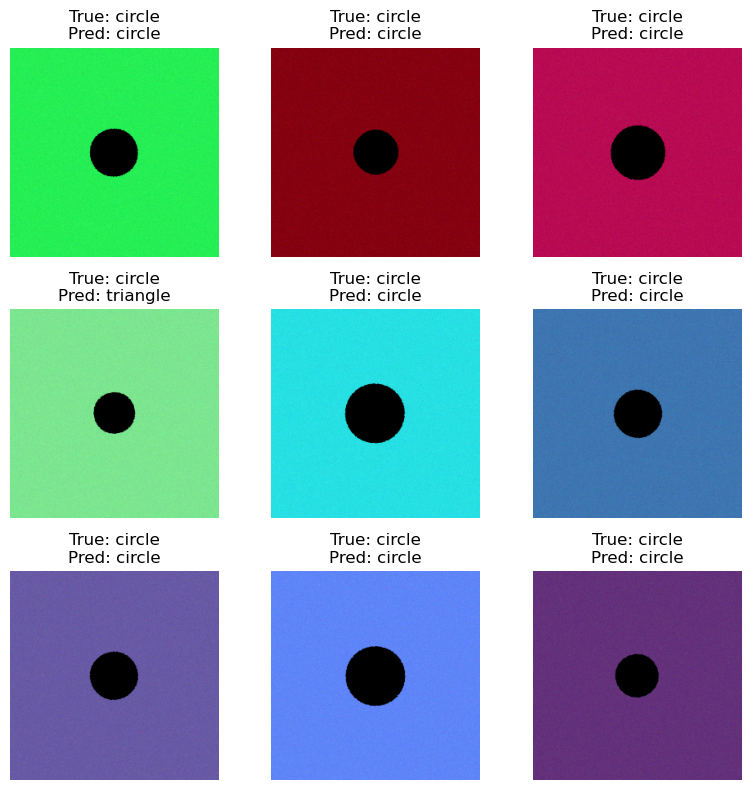

In [34]:

import matplotlib.pyplot as plt
import torch

model.eval()
samples = []
# collect up to 9 test samples
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        preds = model(imgs).argmax(1)
        for img, true, pred in zip(imgs.cpu(), labels.cpu(), preds.cpu()):
            samples.append((img, true.item(), pred.item()))
            if len(samples) >= 9:
                break
        if len(samples) >= 9:
            break

# plot them
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for ax, (img, t, p) in zip(axes.flatten(), samples):
    # un-normalize
    img = img * torch.tensor(std).view(3,1,1) + torch.tensor(mean).view(3,1,1)
    ax.imshow(img.permute(1,2,0).clamp(0,1).numpy())
    ax.set_title(f"True: {train_loader.dataset.classes[t]}\nPred: {train_loader.dataset.classes[p]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


## Train and Val loss and accuracy graph

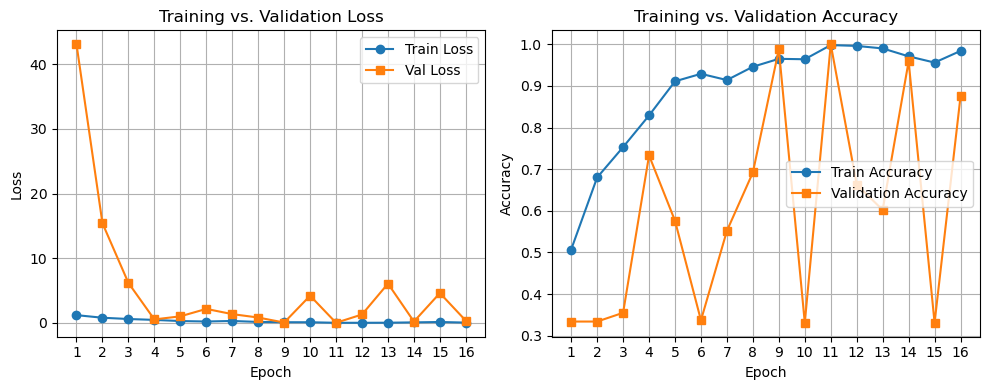

In [35]:
import matplotlib.pyplot as plt

# Logged metrics from training
epochs = list(range(1, 17))
train_loss = [1.2021, 0.8020, 0.6051, 0.4667, 0.2866, 0.2188, 0.3005, 0.1525,
              0.1071, 0.1030, 0.0186, 0.0196, 0.0308, 0.0834, 0.1417, 0.0495]
val_loss   = [43.1098, 15.4211, 6.1910, 0.5408, 1.0183, 2.1675, 1.3606, 0.8336,
              0.0564, 4.2093, 0.0218, 1.3033, 6.0784, 0.2131, 4.6151, 0.3383]
train_acc  = [0.507, 0.680, 0.753, 0.829, 0.911, 0.929, 0.914, 0.946,
              0.965, 0.964, 0.998, 0.996, 0.990, 0.971, 0.956, 0.984]
val_acc    = [0.334, 0.334, 0.355, 0.733, 0.576, 0.337, 0.552, 0.692,
              0.988, 0.331, 1.000, 0.663, 0.602, 0.959, 0.331, 0.875]

# Plot Loss
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss,   marker='s', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy')
plt.plot(epochs, val_acc,   marker='s', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xticks(epochs)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## how can we learn from these dataset and examples. How can we improve the accuracy of the model?

## Some insights

## 1. What the Data Teaches Us
Condition‑dependent performance
Validation accuracy jumped to near‑perfect when seeing size/rotation patterns it had trained on, then crashed when patterns changed—even within the same split. This shows the model was often learning “pixel‑level shortcuts” tied to those specific conditions, rather than the abstract notion of “circle” or “triangle.”

Out‑of‑distribution gaps
Holding out the RLRR condition (random size + random rotation) gave a realistic stress test: hitting ~92% rather than ~100% tells us the model really does generalize, but still stumbles on the most extreme combinations.

Data homogeneity
Because backgrounds, noise levels, and shape fills were always drawn from the same distributions, the network could key off subtle consistency in those patterns. Real‑world images will be far more varied.

## 2. How to Improve Accuracy
A. Make the Model Focus on Shape, Not Artifacts
Stronger, more varied augmentations

360° rotation so the network truly learns rotational invariance.

Affine transforms (small translations, scaling) to force positional robustness.

Color/contrast jitter and varying noise levels on the fly, so backgrounds no longer give away the class.

## Pretrained backbones

Initialize ResNet‑18 (or MobileNetV2) with ImageNet weights. Early filters already know edges and corners, giving you a head start on learning pure geometric shapes.

## Regularization

Dropout before the classifier head (e.g. 0.2–0.3) to prevent co‑adapting to idiosyncratic patterns.

Stronger weight decay (e.g. 5e‑4 or 1e‑3) so weights stay small and generalizable.

## Simpler architectures

A small custom CNN (e.g. TinyConvNet) may actually generalize better on limited synthetic data than a deeper ResNet‑18, since it has less capacity to memorize.

B. Stress‑Test Generalization
Cross‑condition evaluation

Cycle through holding out FLFR, FLRR, RLFR, and RLRR in turn. Averaging performance across all four held‑out tests gives a more stable measure of real shape understanding.

## Edge‑case synthesizing

Generate shapes at extreme sizes (very small or near‑full‑frame), highly skewed rotations, or non‑standard fill patterns (outlines instead of solid) to see where the model breaks.

C. Training Strategies
OneCycleLR schedule

Ramp the learning rate up then down over each epoch to find flatter minima, which often generalize better.

## Label smoothing

Prevent over‑confident predictions (e.g. CrossEntropyLoss(label_smoothing=0.05)) so the model doesn’t “hard‑commit” to every pattern it sees.

## Mixup / CutMix

Combine pairs of images and labels to make the model learn linear combinations of shapes—great for synthetic data.

3. Putting It Into Practice
If we, for example, combine ImageNet pretraining + 360° rotations + dropout (p=0.3) and retrain, you’d likely see:

A smoother validation curve (fewer catastrophic drops).

Higher held‑out‑condition accuracies (≥ 95%).

Better real‑world robustness if you ever move to non‑synthetic inputs.